In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import random
from pathlib import Path
import os

# Image / prétraitement
import SimpleITK as sitk
from skimage.io import imread
from skimage.transform import resize
from skimage.measure import regionprops, moments_hu
from skimage.feature import greycomatrix, greycoprops
from skimage.util import img_as_ubyte

# Analyse / réduction dimensionnelle
from sklearn.decomposition import PCA


In [2]:
# --- Fixer la graine aléatoire pour reproductibilité ---
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

# --- Vérification GPU pour compatibilité torch (optionnelle) ---
import torch
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"✅ Environnement prêt — seed={SEED}, device={device}")


✅ Environnement prêt — seed=42, device=cuda


In [3]:
# Vidage RAM GPU
torch.cuda.empty_cache()

In [4]:
# ===============================================================
# 💾 BACKUP DES PARAMÈTRES ORIGINAUX (pour restauration après test)
# ===============================================================
# Cette cellule sauvegarde les paramètres originaux avant de les modifier pour le test rapide
# Exécutez la cellule de restauration (après les tests) pour remettre les valeurs originales

PARAMS_BACKUP = {
    "SAMPLES_PER_CLASS": 300,  # Valeur originale
    "EPOCHS": 30,               # Valeur originale
    "N_REAL_FID": 96,           # Valeur originale
    "N_FAKE_FID": 96,           # Valeur originale
    "BATCH_SIZE": 8,            # Valeur originale
}

print("✅ Paramètres originaux sauvegardés dans PARAMS_BACKUP")
print(f"   SAMPLES_PER_CLASS: {PARAMS_BACKUP['SAMPLES_PER_CLASS']}")
print(f"   EPOCHS: {PARAMS_BACKUP['EPOCHS']}")
print(f"   N_REAL_FID: {PARAMS_BACKUP['N_REAL_FID']}")
print(f"   N_FAKE_FID: {PARAMS_BACKUP['N_FAKE_FID']}")
print(f"   BATCH_SIZE: {PARAMS_BACKUP['BATCH_SIZE']}")


✅ Paramètres originaux sauvegardés dans PARAMS_BACKUP
   SAMPLES_PER_CLASS: 300
   EPOCHS: 30
   N_REAL_FID: 96
   N_FAKE_FID: 96
   BATCH_SIZE: 8


In [5]:
# --- Imports système et chemins ---
from pathlib import Path
import os

# --- Détection du projet (exécution depuis notebooks/) ---
PROJECT_ROOT = Path(os.getenv("PROJECT_ROOT", "..")).resolve()
DATAGENERATOR_PATH = PROJECT_ROOT / "p9dg"

# Dossiers globaux du projet
MODELS_DIR      = PROJECT_ROOT / "models"
ARTIFACTS_DIR   = PROJECT_ROOT / "artifacts"
SAMPLES_DIR     = PROJECT_ROOT / "samples"     / "05_stylegan"
OUTPUTS_DIR     = PROJECT_ROOT / "outputs"     / "05_stylegan"
CHECKPOINTS_DIR = PROJECT_ROOT / "checkpoints" / "05_stylegan"
RUNS_DIR        = PROJECT_ROOT / "runs"        / "05_stylegan"
DATA_ROOT       = Path(os.getenv("DATA_ROOT", PROJECT_ROOT / "data")).resolve()
CONFIG_DIR      = Path(os.getenv("CONFIG_DIR", PROJECT_ROOT / "configs")).resolve()

# Création des dossiers
for d in [MODELS_DIR, ARTIFACTS_DIR, SAMPLES_DIR, OUTPUTS_DIR, CHECKPOINTS_DIR, RUNS_DIR, CONFIG_DIR]:
    d.mkdir(parents=True, exist_ok=True)

IMAGE_SIZE = 256
# ✅ AMÉLIORATION: Avec une seule classe, on peut augmenter le nombre d'échantillons
SAMPLES_PER_CLASS = 1000  # Augmenté de 300 à 1000 pour avoir plus de données sur la classe TUM
VAHADANE_ENABLE = True
DEVICE = device

# ✅ AMÉLIORATION: Filtrer sur une seule classe stratégique (TUM = tumeur, la plus importante en histopathologie)
SELECTED_CLASSES = ["TUM"]  # Utiliser uniquement la classe TUM pour simplifier l'apprentissage
print(f"✅ Classes sélectionnées: {SELECTED_CLASSES}")
print(f"✅ SAMPLES_PER_CLASS: {SAMPLES_PER_CLASS} (augmenté pour une seule classe)")
print(f"✅ Device utilisé : {DEVICE}")
print(f"✅ PROJECT_ROOT    : {PROJECT_ROOT}")
print(f"✅ DATA_ROOT       : {DATA_ROOT}")
print(f"✅ CONFIG_DIR      : {CONFIG_DIR}")
print(f"✅ MODELS_DIR      : {MODELS_DIR}")
print(f"✅ ARTIFACTS_DIR   : {ARTIFACTS_DIR}")
print(f"✅ SAMPLES_DIR     : {SAMPLES_DIR}")
print(f"✅ OUTPUTS_DIR     : {OUTPUTS_DIR}")
print(f"✅ CHECKPOINTS_DIR : {CHECKPOINTS_DIR}")

✅ Classes sélectionnées: ['TUM']
✅ SAMPLES_PER_CLASS: 1000 (augmenté pour une seule classe)
✅ Device utilisé : cuda
✅ PROJECT_ROOT    : /workspace
✅ DATA_ROOT       : /workspace/data
✅ CONFIG_DIR      : /workspace/configs
✅ MODELS_DIR      : /workspace/models
✅ ARTIFACTS_DIR   : /workspace/artifacts
✅ SAMPLES_DIR     : /workspace/samples/05_stylegan
✅ OUTPUTS_DIR     : /workspace/outputs/05_stylegan
✅ CHECKPOINTS_DIR : /workspace/checkpoints/05_stylegan


In [6]:
# ==== Logger CSV pour métriques d'entraînement ====
from csv import DictWriter
from pathlib import Path

METRICS_CSV = OUTPUTS_DIR / "metrics_gan.csv"

def _csv_write_row(path: Path, row: dict):
    path.parent.mkdir(parents=True, exist_ok=True)
    is_new = not path.exists() or path.stat().st_size == 0
    with path.open("a", newline="") as f:
        w = DictWriter(f, fieldnames=[
            "epoch","step","d_loss","g_loss",
            "real_mu","real_min","real_max",
            "fake_mu","fake_min","fake_max",
            "ada_p","acc","acc_ema","alpha"
        ])
        if is_new:
            w.writeheader()
        w.writerow(row)

def log_metrics_csv(
    epoch:int, step:int,
    d_loss:float, g_loss:float,
    real_mu:float, real_min:float, real_max:float,
    fake_mu:float, fake_min:float, fake_max:float,
    ada_p:float, acc:float, acc_ema:float,
    alpha:float
):
    row = {
        "epoch": epoch, "step": step,
        "d_loss": float(d_loss), "g_loss": float(g_loss),
        "real_mu": float(real_mu), "real_min": float(real_min), "real_max": float(real_max),
        "fake_mu": float(fake_mu), "fake_min": float(fake_min), "fake_max": float(fake_max),
        "ada_p": float(ada_p), "acc": float(acc), "acc_ema": float(acc_ema),
        "alpha": float(alpha),
    }
    _csv_write_row(METRICS_CSV, row)


In [7]:
# ==== Dossier des métriques ====
from pathlib import Path
METRICS_DIR = ARTIFACTS_DIR / "05_stylegan" / "metrics"
METRICS_DIR.mkdir(parents=True, exist_ok=True)
print("✅ METRICS_DIR =", METRICS_DIR.resolve())


✅ METRICS_DIR = /workspace/artifacts/05_stylegan/metrics


In [8]:
# Utiliser DATAGENERATOR_PATH défini dans la cellule précédente
import sys
if str(DATAGENERATOR_PATH) not in sys.path:
    sys.path.append(str(DATAGENERATOR_PATH))

from histo_dataset import HistoDataset
from torch.utils.data import DataLoader

# ===============================================================
# 🧬 DATASET POUR STYLEGAN2
# ===============================================================


# --- Paramètres du dataset ---
SPLIT = "train"                 # pour l'entraînement GAN (toujours "train")
PIXEL_RANGE = "-1_1"            # plage des pixels adaptée au StyleGAN2
RETURN_LABELS = False           # images seules, sans labels
BALANCE_PER_CLASS = True        # équilibre inter-classes (utile pour diversité)
SAMPLES_PER_CLASS = SAMPLES_PER_CLASS  # 300 comme ton param global
VAHADANE_ENABLE = VAHADANE_ENABLE
VAHADANE_DEVICE = DEVICE
THRESHOLDS_JSON_PATH = CONFIG_DIR / "seuils_par_classe.json"

# --- Instanciation du Dataset ---
ds_gan = HistoDataset(
    root_data=str(DATA_ROOT),
    split=SPLIT,
    output_size=IMAGE_SIZE,
    pixel_range=PIXEL_RANGE,
    balance_per_class=BALANCE_PER_CLASS,
    samples_per_class_per_epoch=SAMPLES_PER_CLASS,
    vahadane_enable=VAHADANE_ENABLE,
    vahadane_target_path=str(DATA_ROOT / "NCT-CRC-HE-100K/TUM/TUM-ANVGTFCR.tif"),
    vahadane_device=VAHADANE_DEVICE,
    thresholds_json_path=str(THRESHOLDS_JSON_PATH),
    return_labels=RETURN_LABELS,
    classes=SELECTED_CLASSES,  # ✅ AMÉLIORATION: Filtrer sur une seule classe (TUM)
)

# --- Vérification rapide ---
print("✅ Dataset GAN initialisé")
print(f"Nombre total d'images : {len(ds_gan)}")
print(f"Classes disponibles   : {list(ds_gan.class_counts().keys())}")

# --- Test d'une image ---
sample = ds_gan[0]
print("Taille:", sample.shape, "→ valeurs min/max :", float(sample.min()), float(sample.max()))


🎨 Référence Vahadane fixée : TUM-ANVGTFCR.tif
✅ Seuils par classe chargés depuis : /workspace/configs/seuils_par_classe.json
⚖️ Échantillonnage équilibré activé (1000 images / classe).
✅ Dataset GAN initialisé
Nombre total d'images : 1000
Classes disponibles   : ['TUM']
Taille: torch.Size([3, 256, 256]) → valeurs min/max : -0.929411768913269 1.0


In [9]:
# Extraction et sauvegarde des indices
HELDOUT_IDX_PATH = METRICS_DIR / "duet_eval_idx.npy"
N_EVAL_POOL = 2000  # taille du pool (>= n_real que tu utiliseras pour la mesure)

# Vérifier si les indices sauvegardés sont compatibles avec le dataset actuel
need_recreate = True
if HELDOUT_IDX_PATH.exists():
    eval_idx_old = np.load(HELDOUT_IDX_PATH)
    # Vérifier si les indices sont valides pour le dataset actuel
    if len(eval_idx_old) > 0 and eval_idx_old.max() < len(ds_gan):
        eval_idx = eval_idx_old
        need_recreate = False
        print(f"ℹ️ Indices held-out déjà présents → {HELDOUT_IDX_PATH} ({len(eval_idx)} items)")
    else:
        print(f"⚠️ Indices sauvegardés incompatibles (max={eval_idx_old.max() if len(eval_idx_old) > 0 else 'N/A'}, dataset_size={len(ds_gan)}). Recréation...")

if need_recreate:
    rng = np.random.default_rng(42)  # reproductible
    all_idx = np.arange(len(ds_gan))
    pick = min(N_EVAL_POOL, len(all_idx))
    eval_idx = rng.choice(all_idx, size=pick, replace=False)
    np.save(HELDOUT_IDX_PATH, eval_idx)
    print(f"✅ Indices held-out créés et sauvés → {HELDOUT_IDX_PATH} ({len(eval_idx)} items)")

# petit aperçu
eval_idx[:10]

ℹ️ Indices held-out déjà présents → /workspace/artifacts/05_stylegan/metrics/duet_eval_idx.npy (450 items)


array([214, 245, 145, 442, 364, 183, 256, 420,  28, 258])

In [10]:
# ===============================================================
# ⚙️ DATALOADER POUR STYLEGAN2-ADA
# ===============================================================

from torch.utils.data import DataLoader

# --- Paramètres du loader ---
# ⚡ TEST RAPIDE: Gardé à 8 pour la stabilité (peut être réduit à 4 si besoin)
# 💾 Valeur originale sauvegardée dans PARAMS_BACKUP['BATCH_SIZE'] = 8
BATCH_SIZE = 8             # ✅ QUICK WIN: Augmenté de 4 à 8 pour plus de stabilité (ajuste selon VRAM disponible)
NUM_WORKERS = 0  # moitié des cœurs pour éviter overload CPU os.cpu_count() // 2
PIN_MEMORY = True if DEVICE == "cuda" else False
DROP_LAST = True            # pour stabilité batchnorm et ADA
SHUFFLE = True              # indispensable pour GANs

# --- Création du DataLoader ---
loader_gan = DataLoader(
    dataset=ds_gan,
    batch_size=BATCH_SIZE,
    shuffle=SHUFFLE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    drop_last=DROP_LAST,
)

# --- Test d'un batch ---
batch = next(iter(loader_gan))
print(f"✅ Batch prêt : {batch.shape}")
print(f"→ min={batch.min():.3f}, max={batch.max():.3f}, mean={batch.mean():.3f}")
print(f"→ Mémoire CUDA active : {torch.cuda.memory_allocated() / 1e6:.1f} MB" if DEVICE=="cuda" else "")


✅ Batch prêt : torch.Size([8, 3, 256, 256])
→ min=-0.984, max=1.000, mean=0.264
→ Mémoire CUDA active : 8.9 MB


In [11]:
# =====================================================================================
# ⚙️ DATALOADER NON-SHUFFLE sur les indices held-out (pour calcul métrique FID-pahto
# =====================================================================================

from torch.utils.data import DataLoader, Subset

ds_eval = Subset(ds_gan, eval_idx.tolist())
loader_real_eval = DataLoader(
    ds_eval,
    batch_size=BATCH_SIZE,
    shuffle=False,     # ← crucial
    num_workers=NUM_WORKERS,     # reste modeste
    pin_memory=PIN_MEMORY   # sécurité si tu as déjà vu des erreurs "pin memory"
)
print("✅ loader_real_eval prêt :", len(ds_eval), "échantillons")



✅ loader_real_eval prêt : 450 échantillons


In [12]:
xb = next(iter(loader_real_eval))
print("batch shape:", xb.shape, "dtype:", xb.dtype)
print("min/max:", float(xb.min()), float(xb.max()))  # attendu ~ -1.0 / +1.0


batch shape: torch.Size([8, 3, 256, 256]) dtype: torch.float32
min/max: -0.9764705896377563 1.0


## 🧬 Instanciation de Pathoduet (pour un discriminateur à deux têtes)

In [13]:
# ==== Chargement "safe" du checkpoint PathoDuet (corrige le warning) ====
from pathlib import Path
import torch
import re, json

CKPT_PATH = MODELS_DIR / "checkpoint_HE.pth" 
assert CKPT_PATH.exists(), f"Checkpoint introuvable: {CKPT_PATH.resolve()}"

def load_state_dict_safely(path):
    """
    1) Tente torch.load(..., weights_only=True) -> évite l'unpickling arbitraire.
    2) Si la version de torch ne supporte pas 'weights_only', fallback minimal:
       - charge le dict
       - extrait uniquement un state_dict plausible (clés -> tensors)
       - nettoie les préfixes 'module.' / 'model.'
    """
    sd_raw = None
    try:
        # PyTorch >= 2.4 (selon installations) : évite le warning et sécurise le chargement
        obj = torch.load(path, map_location="cpu", weights_only=True)  # <-- clé pour supprimer le warning
        # Selon la façon dont le checkpoint a été sauvegardé, obj peut déjà être un state_dict
        if isinstance(obj, dict) and all(hasattr(v, "shape") for v in obj.values()):
            sd_raw = obj
        elif isinstance(obj, dict):
            # Cherche une clé 'state_dict'/'model' plausible
            for k in ("state_dict", "model", "module"):
                if k in obj and isinstance(obj[k], dict):
                    cand = obj[k]
                    if all(hasattr(v, "shape") for v in cand.values()):
                        sd_raw = cand
                        break
        if sd_raw is None:
            # Si ce n'est toujours pas clair, prends le plus gros sous-dict de tensors
            candidates = [v for v in (obj.values() if isinstance(obj, dict) else []) if isinstance(v, dict)]
            if candidates:
                cand = max(candidates, key=lambda d: sum(getattr(v, "numel", lambda:0)() for v in d.values() if hasattr(v,"numel")))
                if all(hasattr(v, "shape") for v in cand.values()):
                    sd_raw = cand
        if sd_raw is None:
            raise RuntimeError("Impossible d'identifier un state_dict dans le checkpoint (mode safe).")
    except TypeError:
        # Fallback pour versions de torch sans 'weights_only'
        obj = torch.load(path, map_location="cpu")
        # on limite au strict nécessaire: un dict de tensors
        if isinstance(obj, dict) and all(hasattr(v, "shape") for v in obj.values()):
            sd_raw = obj
        elif isinstance(obj, dict):
            for k in ("state_dict", "model", "module"):
                if k in obj and isinstance(obj[k], dict) and all(hasattr(v, "shape") for v in obj[k].values()):
                    sd_raw = obj[k]; break
            if sd_raw is None:
                candidates = [v for v in obj.values() if isinstance(v, dict)]
                if candidates:
                    cand = max(candidates, key=lambda d: sum(getattr(v, "numel", lambda:0)() for v in d.values() if hasattr(v,"numel")))
                    if all(hasattr(v, "shape") for v in cand.values()):
                        sd_raw = cand
        if sd_raw is None:
            raise RuntimeError("Impossible d'identifier un state_dict dans le checkpoint (fallback).")

    # Nettoyage des clés "module." / "model."
    clean_sd = {}
    for k, v in sd_raw.items():
        nk = re.sub(r"^(module\.|model\.)", "", k)
        clean_sd[nk] = v
    return clean_sd

# ----- Charge "safe" -----
state_dict = load_state_dict_safely(CKPT_PATH)

# Petit résumé (comme avant), sans warning
meta = {}
# patch_embed weight shape
for k in ["patch_embed.proj.weight", "patch_embed.weight"]:
    if k in state_dict:
        ws = state_dict[k].shape
        meta["patch_embed_weight_shape"] = list(map(int, ws))
        meta["in_ch"] = int(ws[1]) if len(ws) == 4 else None
        meta["kernel_hw"] = [int(ws[2]), int(ws[3])] if len(ws) == 4 else None
        break
# pos_embed
for k in ["pos_embed", "positional_embedding", "positional_embed"]:
    if k in state_dict:
        meta["pos_embed_shape"] = list(map(int, state_dict[k].shape))
        break
# head dims
for k in ["head.weight","classifier.weight","fc.weight"]:
    if k in state_dict:
        out_dim, embed_dim = state_dict[k].shape
        meta["head_out_dim"] = int(out_dim); meta["embed_dim_guess"] = int(embed_dim)
        break
meta["has_fc_norm"] = any(k.startswith("fc_norm") for k in state_dict.keys())
meta["has_cls_token"] = "cls_token" in state_dict
meta["num_params_in_state_dict"] = int(sum(p.numel() for p in state_dict.values()))

print("Chargement OK (safe). Résumé :")
for k, v in meta.items():
    print(f"{k}: {v}")


Chargement OK (safe). Résumé :
patch_embed_weight_shape: [768, 3, 16, 16]
in_ch: 3
kernel_hw: [16, 16]
pos_embed_shape: [1, 198, 768]
has_fc_norm: True
has_cls_token: True
num_params_in_state_dict: 85800192


In [14]:
# ==== Prétraitement PathoDuet (sans rien casser côté GAN) ====
import torch
import torch.nn.functional as F

# Constantes pour PathoDuet (déduites du checkpoint)
DUET_IN_SIZE = 224     # attendu par le pos_embed (14x14 patches de 16)
DUET_FEAT_DIM = 768    # ViT-B/16 (embedding)

def to_duet_input(x_minus1_1: torch.Tensor, size: int = DUET_IN_SIZE) -> torch.Tensor:
    """
    x_minus1_1 : images GAN en [-1,1], forme (B,3,H,W) — p.ex. H=W=256.
    Retourne   : images en [0,1], redimensionnées à (size,size), SANS normalisation ImageNet.
    """
    # 1) [-1,1] -> [0,1]
    x01 = (x_minus1_1 + 1.0) * 0.5
    # 2) Resize vers 224x224 si nécessaire
    if x01.shape[-2:] != (size, size):
        x01 = F.interpolate(x01, size=(size, size), mode="bilinear", align_corners=False)
    return x01.clamp(0, 1)

# --- Petit test à blanc (ne modifie rien) ---
device = "cuda" if torch.cuda.is_available() else "cpu"
xb = next(iter(loader_gan))  # batch issu de TON DataLoader GAN (en [-1,1])
xb = xb.to(device, non_blocking=True)

# Vérif ranges/tailles côté flux GAN
gan_min, gan_max = xb.min().item(), xb.max().item()
gan_shape = tuple(xb.shape)

# Construction de l'entrée PathoDuet (copie transformée)
xb_duet = to_duet_input(xb)  # [0,1] et 224x224
duet_min, duet_max = xb_duet.min().item(), xb_duet.max().item()
duet_shape = tuple(xb_duet.shape)

print(f"[GAN ] shape={gan_shape} range=[{gan_min:.3f}, {gan_max:.3f}]  (doit rester ~[-1, 1])")
print(f"[DUET] shape={duet_shape} range=[{duet_min:.3f}, {duet_max:.3f}] (doit être [0, 1])")

# Sanity check strict (peut lever une AssertionError si qqch cloche)
assert gan_min >= -1.01 and gan_max <= 1.01, "Le flux GAN n'est plus en [-1,1] !"
assert duet_min >= -1e-6 and duet_max <= 1.0 + 1e-6, "Le flux DUET n'est pas en [0,1] !"
assert duet_shape[-1] == DUET_IN_SIZE and duet_shape[-2] == DUET_IN_SIZE, "Taille DUET incorrecte !"

print("OK: Prétraitement PathoDuet prêt. Aucune modification du pipeline GAN.")


[GAN ] shape=(8, 3, 256, 256) range=[-0.929, 1.000]  (doit rester ~[-1, 1])
[DUET] shape=(8, 3, 224, 224) range=[0.047, 1.000] (doit être [0, 1])
OK: Prétraitement PathoDuet prêt. Aucune modification du pipeline GAN.


In [15]:
# ! pip install timm

In [16]:
# ==== PathoDuet (HE) — Extracteur gelé via timm (DeiT Base distillé 224) ====
from pathlib import Path
import torch, re
import torch.nn as nn
import torch.nn.functional as F

try:
    import timm
except ImportError as e:
    raise RuntimeError("Le package 'timm' est requis. Installe-le avec: pip install timm") from e

CKPT_PATH = MODELS_DIR / "checkpoint_HE.pth" 
assert CKPT_PATH.exists(), f"Checkpoint introuvable: {CKPT_PATH.resolve()}"

# -- Chargement "safe" du state_dict (sans warning / pickle) --
def load_state_dict_safely(path):
    sd_raw = None
    try:
        obj = torch.load(path, map_location="cpu", weights_only=True)  # safe mode (torch récents)
        if isinstance(obj, dict) and all(hasattr(v, "shape") for v in obj.values()):
            sd_raw = obj
        elif isinstance(obj, dict):
            for k in ("state_dict", "model", "module"):
                if k in obj and isinstance(obj[k], dict) and all(hasattr(v, "shape") for v in obj[k].values()):
                    sd_raw = obj[k]; break
            if sd_raw is None:
                cands = [v for v in obj.values() if isinstance(v, dict)]
                if cands:
                    sd_raw = max(cands, key=lambda d: sum(getattr(v, "numel", lambda:0)() for v in d.values() if hasattr(v,"numel")))
    except TypeError:
        obj = torch.load(path, map_location="cpu")  # fallback
        if isinstance(obj, dict) and all(hasattr(v, "shape") for v in obj.values()):
            sd_raw = obj
        elif isinstance(obj, dict):
            for k in ("state_dict", "model", "module"):
                if k in obj and isinstance(obj[k], dict) and all(hasattr(v, "shape") for v in obj[k].values()):
                    sd_raw = obj[k]; break
            if sd_raw is None:
                cands = [v for v in obj.values() if isinstance(v, dict)]
                if cands:
                    sd_raw = max(cands, key=lambda d: sum(getattr(v, "numel", lambda:0)() for v in d.values() if hasattr(v,"numel")))

    if sd_raw is None:
        raise RuntimeError("Impossible d'identifier un state_dict dans le checkpoint.")
    # strip prefixes 'module.' / 'model.'
    clean_sd = {re.sub(r"^(module\.|model\.)","",k): v for k, v in sd_raw.items()}
    return clean_sd

state_dict = load_state_dict_safely(CKPT_PATH)

# -- Adapter le checkpoint distillé -> modèle non distillé (on retire le token de distillation)
#    - supprimer 'dist_token' et 'head_dist.*'
#    - recaler 'pos_embed' de [1, 198, 768] -> [1, 197, 768] en enlevant le 2e token
if "dist_token" in state_dict:
    state_dict.pop("dist_token")
for k in list(state_dict.keys()):
    if k.startswith("head_dist."):
        state_dict.pop(k)

if "pos_embed" in state_dict and state_dict["pos_embed"].shape[1] == 198:
    pos = state_dict["pos_embed"]  # [1, 198, 768] = [cls, dist, 196*patch]
    # garder cls (idx 0) + 196 patchs (idx 2..)
    new_pos = torch.cat([pos[:, :1, :], pos[:, 2:, :]], dim=1)  # -> [1, 197, 768]
    state_dict["pos_embed"] = new_pos

# -- Crée le backbone non distillé, avec global_pool='avg' & num_classes=0 (features 768-D)
model_duet = timm.create_model(
    "deit_base_patch16_224",  # NON distillé
    pretrained=False,
    num_classes=0,            # => la sortie est (B, 768)
    img_size=224,
    global_pool="avg"         # pooling moyen des patchs (fc_norm actif)
)

# supprimer au besoin d'autres têtes
for k in list(state_dict.keys()):
    if k.startswith("head."):  # tête de classification
        state_dict.pop(k)

missing, unexpected = model_duet.load_state_dict(state_dict, strict=False)
print(f"[PathoDuet] load_state_dict -> missing: {len(missing)}, unexpected: {len(unexpected)}")
if unexpected:
    print("  unexpected:", unexpected[:6], "..." if len(unexpected) > 6 else "")
if missing:
    print("  missing   :", missing[:6], "..." if len(missing) > 6 else "")

# Gèle + eval
for p in model_duet.parameters():
    p.requires_grad_(False)
model_duet.eval()

# Wrapper extracteur (attend x en [-1,1], renvoie (B,768))
class PathoDuetExtractor(nn.Module):
    def __init__(self, backbone, in_size=224):
        super().__init__()
        self.backbone = backbone
        self.in_size = in_size

    @torch.no_grad()
    def forward(self, x_minus1_1: torch.Tensor) -> torch.Tensor:
        x01 = (x_minus1_1 + 1.0) * 0.5
        if x01.shape[-2:] != (self.in_size, self.in_size):
            x01 = F.interpolate(x01, size=(self.in_size, self.in_size), mode="bilinear", align_corners=False)
        feats = self.backbone(x01)  # (B, 768)
        return feats

# Instancie sur device + smoke test
device = "cuda" if torch.cuda.is_available() else "cpu"
pathoduet = PathoDuetExtractor(model_duet).to(device)

xb = next(iter(loader_gan)).to(device, non_blocking=True)
with torch.no_grad():
    f = pathoduet(xb)
print(f"OK PathoDuetExtractor -> features: shape={tuple(f.shape)} (attendu: (B, 768))")

[PathoDuet] load_state_dict -> missing: 0, unexpected: 1
  unexpected: ['pretext_token'] 
OK PathoDuetExtractor -> features: shape=(8, 768) (attendu: (B, 768))


In [17]:
# === Duet-FID (helpers + logger CSV) — idempotent, no-TensorBoard ===
import os, csv, torch, torch.nn.functional as F

DUET_CSV_PATH = METRICS_DIR / "duet_fid.csv"
if DUET_CSV_PATH.exists():
    DUET_CSV_PATH.unlink()
    print("✅ duet_fid.csv réinitialisé:", DUET_CSV_PATH)

if 'duet_frechet' not in globals():

    @torch.no_grad()
    def _resize_224(x_m11):  # x: BCHW in [-1,1]
        x01 = (x_m11.clamp(-1, 1) + 1) * 0.5
        return F.interpolate(x01, size=(224, 224), mode="bilinear", align_corners=False)

    @torch.no_grad()
    def _feat_duet(x01_224):  # x: [0,1], BCHW -> (B,768)
        assert 'pathoduet' in globals(), (
            "Variable 'pathoduet' introuvable. "
            "Charge d'abord ton extracteur PathoDuet dans une variable nommée 'pathoduet'."
        )
        m = pathoduet
        # sécurité : device + état
        was_training = m.training if hasattr(m, "training") else False
        if hasattr(m, 'parameters'):
            try:
                dev_m = next(m.parameters()).device
                if dev_m != x01_224.device:
                    m = m.to(x01_224.device)
            except StopIteration:
                pass
        m.eval()
        f = m(x01_224)  # attendu: (B, 768)
        if was_training and hasattr(m, "train"):
            m.train()
        return f

    @torch.no_grad()
    def _moments(feats):  # feats: (N, D)
        mu = feats.mean(dim=0)
        xc = feats - mu
        cov = (xc.t() @ xc) / (feats.size(0) - 1 + 1e-8)
        return mu, cov

    def _frechet(mu1, cov1, mu2, cov2, eps=1e-6):
        m1 = mu1.double(); m2 = mu2.double()
        C1 = cov1.double(); C2 = cov2.double()
        diff = (m1 - m2)
        eva1, eve1 = torch.linalg.eigh(C1 + eps*torch.eye(C1.shape[0], device=C1.device))
        eva2, eve2 = torch.linalg.eigh(C2 + eps*torch.eye(C2.shape[0], device=C2.device))
        C1h = (eve1 @ torch.diag_embed(torch.clamp(eva1, min=0).sqrt()) @ eve1.transpose(-1,-2))
        C2h = (eve2 @ torch.diag_embed(torch.clamp(eva2, min=0).sqrt()) @ eve2.transpose(-1,-2))
        prod = C1h @ C2h
        evaP, eveP = torch.linalg.eigh(prod @ prod)
        sqrt_prod = (eveP @ torch.diag_embed(torch.clamp(evaP, min=0).sqrt()) @ eveP.transpose(-1,-2))
        tr_term = torch.trace(C1 + C2 - 2*sqrt_prod)
        return (diff @ diff).item() + tr_term.item()

    @torch.no_grad()
    def duet_frechet(real_batch_iter, G_ema, z_dim, n_real=128, n_fake=128, device=None):
        dev = device or next(G_ema.parameters()).device
        # 1) Real feats
        feats_real, n_acc = [], 0
        for x in real_batch_iter:
            x = x.to(dev, non_blocking=False)
            x224 = _resize_224(x)
            f = _feat_duet(x224)
            feats_real.append(f)
            n_acc += x.size(0)
            if n_acc >= n_real:
                break
        feats_real = torch.cat(feats_real, dim=0)[:n_real]

        # 2) Fake feats (G_ema)
        z = torch.randn(n_fake, z_dim, device=dev)
        fake = G_ema(z)
        f224 = _resize_224(fake)
        feats_fake = _feat_duet(f224)

        # 3) Moments + Fréchet
        mu_r, cov_r = _moments(feats_real)
        mu_f, cov_f = _moments(feats_fake)
        return float(_frechet(mu_r, cov_r, mu_f, cov_f))

    def log_duet_fid(step, value, csv_path=DUET_CSV_PATH):
        os.makedirs(os.path.dirname(csv_path), exist_ok=True)
        new = not os.path.exists(csv_path)
        with open(csv_path, "a", newline="") as f:
            w = csv.writer(f)
            if new:
                w.writerow(["global_step", "duet_fid"])
            w.writerow([int(step), float(value)])

print("✅ Duet-FID helpers prêts →", DUET_CSV_PATH)


✅ duet_fid.csv réinitialisé: /workspace/artifacts/05_stylegan/metrics/duet_fid.csv
✅ Duet-FID helpers prêts → /workspace/artifacts/05_stylegan/metrics/duet_fid.csv


## 🧬 Cellule : Initialisation StyleGAN2-ADA Vanilla (PyTorch)

In [18]:
# ===============================================================
# 🧠 STYLEGAN2-VANILLA (POC)
# ===============================================================
import torch
import torch.nn as nn
import torch.nn.functional as F

class MappingNetwork(nn.Module):
    def __init__(self, z_dim=512, w_dim=512, n_layers=8):
        super().__init__()
        layers = []
        for _ in range(n_layers):
            layers += [nn.Linear(z_dim, w_dim), nn.LeakyReLU(0.2, inplace=True)]
            z_dim = w_dim
        self.mapping = nn.Sequential(*layers)

    def forward(self, z):
        z = z / (z.norm(dim=1, keepdim=True) + 1e-8)
        return self.mapping(z)

class ModulatedConv2d(nn.Module):
    def __init__(self, in_ch, out_ch, kernel, style_dim, demod=True, up=False):
        super().__init__()
        self.up = up
        self.weight = nn.Parameter(torch.randn(1, out_ch, in_ch, kernel, kernel))
        self.style = nn.Linear(style_dim, in_ch)
        self.demod = demod
        self.eps = 1e-8
        self.pad = kernel // 2

    def forward(self, x, s):
        if self.up:
            # upsample x2 avant la conv (StyleGAN fait un upsample + blur; ici: up simple pour POC)
            x = F.interpolate(x, scale_factor=2, mode="nearest")
        b, c, h, w = x.shape
        w1 = self.style(s).view(b, 1, c, 1, 1)
        w2 = self.weight * (w1 + 1)
        if self.demod:
            d = torch.rsqrt((w2 ** 2).sum([2, 3, 4]) + self.eps)
            w2 = w2 * d.view(b, -1, 1, 1, 1)
        x = x.view(1, -1, h, w)
        w2 = w2.view(b * w2.size(1), w2.size(2), w2.size(3), w2.size(4))
        out = F.conv2d(x, w2, padding=self.pad, groups=b)
        out = out.view(b, -1, out.shape[-2], out.shape[-1])
        return out

class Generator(nn.Module):
    def __init__(self, z_dim=512, w_dim=512, img_res=256, fmap_base=256):
        super().__init__()
        self.mapping = MappingNetwork(z_dim, w_dim)
        self.const = nn.Parameter(torch.randn(1, fmap_base, 4, 4))

        # ✅ AMÉLIORATION: Noise injection pour chaque bloc
        self.num_blocks = 0  # Compteur de blocs pour noise injection

        # on construit explicitement les étages 4→8→…→img_res
        self.blocks = nn.ModuleList()
        in_ch = fmap_base
        res = 4
        while res < img_res:
            out_ch = max(fmap_base // max(res // 8, 1), 64)
            # ✅ AMÉLIORATION: Ajouter du bruit appris pour plus de détails et de diversité
            noise_weight = nn.Parameter(torch.zeros(1, out_ch, 1, 1))
            self.register_parameter(f'noise_{self.num_blocks}', noise_weight)
            # bloc = [upsample, modconv, LReLU, modconv, LReLU] (comme StyleGAN2 sans blur)
            self.blocks.append(nn.ModuleList([
                ModulatedConv2d(in_ch, out_ch, 3, w_dim, up=True),
                nn.LeakyReLU(0.2, inplace=True),
                ModulatedConv2d(out_ch, out_ch, 3, w_dim, up=False),
                nn.LeakyReLU(0.2, inplace=True),
            ]))
            in_ch = out_ch
            res *= 2
            self.num_blocks += 1
        self.to_rgb = nn.Conv2d(in_ch, 3, 1)
        # ✅ AMÉLIORATION: Initialisation Xavier pour to_rgb (meilleure initialisation)
        nn.init.xavier_uniform_(self.to_rgb.weight, gain=0.8)
        if self.to_rgb.bias is not None:
            nn.init.constant_(self.to_rgb.bias, 0.0)

    def forward(self, z):
        w = self.mapping(z)
        x = self.const.repeat(z.size(0), 1, 1, 1)
        for i, (m1, a1, m2, a2) in enumerate(self.blocks):
            x = m1(x, w)
            # ✅ AMÉLIORATION: Noise injection
            if self.training:
                noise = torch.randn(x.size(0), 1, x.size(2), x.size(3), device=x.device)
                noise_weight = getattr(self, f'noise_{i}')
                # Adapter la taille du noise_weight si nécessaire
                if noise_weight.shape[1] != x.shape[1]:
                    noise_weight_adj = noise_weight[:, :1, :, :]
                else:
                    noise_weight_adj = noise_weight
                x = x + noise * noise_weight_adj
            x = a1(x)
            x = m2(x, w)
            # Noise après la deuxième conv aussi (même poids)
            if self.training:
                noise = torch.randn(x.size(0), 1, x.size(2), x.size(3), device=x.device)
                noise_weight = getattr(self, f'noise_{i}')
                if noise_weight.shape[1] != x.shape[1]:
                    noise_weight_adj = noise_weight[:, :1, :, :]
                else:
                    noise_weight_adj = noise_weight
                x = x + noise * noise_weight_adj
            x = a2(x)
        # ✅ AMÉLIORATION: Protection contre la saturation - clamp plus strict
        img = torch.tanh(self.to_rgb(x))
        # Clamp à [-0.9, 0.9] au lieu de [-1, 1] pour éviter la saturation
        img = img.clamp(-0.9, 0.9)
        return img


In [19]:
# ----------------------------
# Discriminator
# ----------------------------
import torch.nn.utils as nn_utils

class Discriminator(nn.Module):
    def __init__(self, ch=64):
        super().__init__()
        def C(in_c, out_c, k=3, s=2, p=1):
            return nn_utils.spectral_norm(nn.Conv2d(in_c, out_c, k, s, p))
        self.net = nn.Sequential(
            C(3,     ch,   3, 2, 1), nn.LeakyReLU(0.2, inplace=True),   # 256->128
            C(ch,    ch*2, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True),   # 128->64
            C(ch*2,  ch*4, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True),   # 64->32
            C(ch*4,  ch*8, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True),   # 32->16
            C(ch*8,  ch*8, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True),   # 16->8
            C(ch*8,  ch*8, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True),   # 8->4
            C(ch*8,  ch*8, 4, 1, 0), nn.LeakyReLU(0.2, inplace=True),   # 4->1
            nn_utils.spectral_norm(nn.Conv2d(ch*8, 1, 1, 1, 0)),
        )
        # ✅ AMÉLIORATION: Stocker les features pour feature matching loss
        self.out_ch = ch * 8
    def forward(self, x):
        # ✅ AMÉLIORATION: Retourner aussi les features intermédiaires
        h = x
        for i, layer in enumerate(self.net):
            h = layer(h)
            # Prendre les features avant la dernière couche (avant le logit final)
            if i == len(self.net) - 2:  # Avant la dernière couche (logit)
                feat = h.view(x.size(0), self.out_ch)
        logit = h.view(x.size(0))
        return logit, feat




In [20]:
def trace_shapes_D(model, x):
    print("D input:", tuple(x.shape))
    for i, m in enumerate(model.net):
        x = m(x)
        print(f"{i:02d} {m.__class__.__name__:<12} -> {tuple(x.shape)}")
    return x

def trace_shapes_G(G, z):
    print("G input:", tuple(z.shape))
    x = G.const.repeat(z.size(0), 1, 1, 1)
    print(" after const:", tuple(x.shape))
    for bi, (m1,a1,m2,a2) in enumerate(G.blocks):
        x = m1(x, G.mapping(z)); print(f" up{bi}: {tuple(x.shape)}")
        x = a1(x)
        x = m2(x, G.mapping(z)); print(f" conv{bi}: {tuple(x.shape)}")
        x = a2(x)
    y = torch.tanh(G.to_rgb(x))
    print(" to_rgb:", tuple(y.shape))
    return y


In [21]:
Z_DIM = 512
IMG_RES = 256
FMAP_BASE = 256
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

G = Generator(z_dim=Z_DIM, w_dim=Z_DIM, img_res=IMG_RES, fmap_base=FMAP_BASE).to(DEVICE)
D = Discriminator(ch=64).to(DEVICE)

z = torch.randn(4, Z_DIM, device=DEVICE)

In [22]:
# ==== Discriminateur combiné: base + branche PathoDuet (logits sommés) ====
import torch
import torch.nn as nn

class DuetLogitHead(nn.Module):
    """
    Petite tête MLP qui convertit les features 768-D de PathoDuet en un logit (B,1).
    Paramètres entraînables. Pas de normalisation ImageNet requise (déjà gérée en amont).
    """
    def __init__(self, in_dim=768, hidden=512):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden, 1)
        )
    def forward(self, f):  # f: (B,768)
        return self.mlp(f)  # (B,1)

class CombinedDiscriminator(nn.Module):
    """
    Wrap le discriminateur de base (qui sort un logit) et ajoute une branche PathoDuet.
    logit_total = logit_base + alpha * logit_duet
    - base_disc : ton D existant (inchangé)
    - duet_extractor : PathoDuetExtractor (gelé, mais PAS de torch.no_grad() ici pour que R1 voie le chemin)
    - duet_head : MLP -> logit (entraînable)
    """
    def __init__(self, base, duet_extractor, alpha=0.0, t_duet=2.0):
        super().__init__()
        self.base = base
        self.duet = duet_extractor
        self.duet_head = nn.Linear(768, 1)
        self.alpha = alpha
        self.t_duet = t_duet

    def forward(self, x_minus1_1):
        # ✅ CORRECTION: Le discriminateur de base retourne maintenant (logit, feat)
        logit_base, feat_base = self.base(x_minus1_1)
        if logit_base.ndim == 1:
            logit_base = logit_base.unsqueeze(1)
        with torch.no_grad():
            f_duet = self.duet(x_minus1_1)
        logit_duet = self.duet_head(f_duet)
        if self.t_duet and self.t_duet > 1.0:
            logit_duet = logit_duet / self.t_duet  # <<< soft
        logit_total = logit_base + self.alpha * logit_duet
        return logit_total, feat_base  # ✅ Retourner aussi les features pour feature matching


# ---- Intégration : remplace D par un wrapper combiné (aucun autre changement ailleurs) ----
device = "cuda" if torch.cuda.is_available() else "cpu"

# On suppose que:
# - 'D' est ton discriminateur actuel (déjà instancié)
# - 'pathoduet' est l'extracteur validé précédemment (OK features (B,768))
D_base = D
D = CombinedDiscriminator(D_base, pathoduet, alpha=0.0, t_duet=2.0).to(DEVICE)


# ---- Smoke test (forward + simple loss) ----
xb = next(iter(loader_gan)).to(device, non_blocking=True)  # batch en [-1,1]
out, feat = D(xb)                       # (B,1), (B, out_ch)
print("Combined D output shape:", tuple(out.shape))
print("Combined D features shape:", tuple(feat.shape))
assert out.shape[0] == xb.shape[0] and out.shape[1] == 1

# mini-test backward (sans step) pour vérifier que le grad remonte jusqu'à x (utile pour R1)
out.mean().backward(retain_graph=True)
print("Backward OK (grad jusqu'à l'entrée activé).")

# Remarque : tes optimisateurs existants qui faisaient opt_D = Adam(D.parameters(), ...)
# incluront automatiquement la tête duet_head (entraînable) + D_base (entraînable),
# tandis que 'pathoduet' reste gelé.


Combined D output shape: (8, 1)
Combined D features shape: (8, 512)
Backward OK (grad jusqu'à l'entrée activé).


In [23]:
# Optionnel: tracer
# fake_dbg = trace_shapes_G(G, z)
# _ = trace_shapes_D(D, fake_dbg.clone())

fake = G(z)
print("fake:", fake.shape)             # → torch.Size([4, 3, 256, 256])
out, feat = D(fake)
print("D out:", out.shape)             # → torch.Size([4, 1])
print("D feat:", feat.shape)           # → torch.Size([4, out_ch])

fake: torch.Size([4, 3, 256, 256])
D out: torch.Size([4, 1])
D feat: torch.Size([4, 512])


In [24]:
# Vidage RAM GPU
torch.cuda.empty_cache()


# 🔁 ENTRAÎNEMENT STYLEGAN2 (NS-GAN + R1 + EMA + ADA minimal)


In [25]:
# ===============================================================
# 🔁 ENTRAÎNEMENT STYLEGAN2 (NS-GAN + R1 + EMA + ADA minimal)
# ===============================================================
import time, torch
import torch.nn.functional as F
from torch import nn
import torchvision.utils as vutils
import math  # ✅ Pour la rotation dans ada_augment

# ----- Utils requis dans cette cellule -----
def requires_grad(model: nn.Module, flag: bool = True):
    for p in model.parameters():
        p.requires_grad_(flag)

@torch.no_grad()
def ema_update(ema_model: nn.Module, model: nn.Module, decay=0.9995):
    for p_ema, p in zip(ema_model.parameters(), model.parameters()):
        p_ema.data.mul_(decay).add_(p.data, alpha=1.0 - decay)

# ------------------------
# Hyperparamètres mis à jour
# ------------------------
# ⚡ TEST RAPIDE: Réduit à 1 epoch pour tester rapidement l'activation du gate
# 💾 Valeur originale sauvegardée dans PARAMS_BACKUP['EPOCHS'] = 30
EPOCHS       = 3   # ⚡ TEST: 1 au lieu de 30 (restaurer après test)
Z_DIM        = 512
LR_G         = 5e-4
LR_D         = 1.5e-4  # ✅ Ajusté: LR D réduit pour ralentir le discriminateur (était 2e-4)
BETAS        = (0.0, 0.99)
R1_GAMMA     = 10.0
R1_EVERY     = 8  # 16 initialement
EMA_DECAY    = 0.9995
SAMPLE_EVERY = 400
SAVE_EVERY   = 800

# État ADA (mutable) : proba p + accuracy lissée
ADA_STATE = {"p": 0.0, "acc_ema": None}
ADA_TARGET = 0.6
ADA_DECAY  = 0.99
ADA_SPEED = 0.25    # + doux, mais borné par ADA_P_STEP_MAX
ADA_MAX_P = 0.08      # cap plus bas au début 0.4-06 visé
ADA_FREEZE_UNTIL = 500    # ✅ Ajusté: ADA activé plus tôt pour aider le générateur (était 1800)
ADA_UPDATE_EVERY = 8      # n'update p que 1 fois / 8 steps
ADA_P_STEP_MAX   = 0.001  # variation max par update (initial 0.004)
ADA_DEADBAND     = 0.02

# ------------------------
# Optim & AMP off & EMA 
# ------------------------
opt_G = torch.optim.Adam(G.parameters(), lr=LR_G, betas=BETAS)
opt_D = torch.optim.Adam(D.parameters(), lr=LR_D, betas=BETAS)
for pg in opt_D.param_groups:
    pg["lr"] *= 0.5
print("[info] lr(D) réduit x0.5 =", opt_D.param_groups[0]["lr"])
# Idempotent: n’applique la baisse qu’une seule fois même si la cellule est relancée
if "LR_G_BASE" not in globals():
    LR_G_BASE = LR_G  # garde une trace du LR d'origine (5e-4)
if "LR_G_TWEAKED" not in globals() or not LR_G_TWEAKED:
    LR_G = LR_G_BASE * 0.8  # 5e-4 -> 4e-4
    for pg in opt_G.param_groups:
        pg["lr"] = LR_G
    LR_G_TWEAKED = True
print(f"[info] lr(G) ajusté à {LR_G:.6f}")

# ===== Learning Rate Scheduler (Cosine Annealing) =====
# ✅ AMÉLIORATION: Scheduler pour réduire progressivement le LR et améliorer la convergence
from torch.optim.lr_scheduler import CosineAnnealingLR, LambdaLR

# Calculer le nombre total de steps (sera recalculé après création du loader)
# Estimation initiale, sera mis à jour dans la boucle d'entraînement
TOTAL_STEPS = EPOCHS * 337  # ~337 steps par epoch avec 2700 images / batch_size 8

# Scheduler pour G et D avec cosine annealing
# Le LR décroît progressivement de LR initial à LR_final sur TOTAL_STEPS
LR_FINAL_RATIO = 0.01  # LR final = 1% du LR initial
scheduler_G = CosineAnnealingLR(opt_G, T_max=TOTAL_STEPS, eta_min=LR_G * LR_FINAL_RATIO)
scheduler_D = CosineAnnealingLR(opt_D, T_max=TOTAL_STEPS, eta_min=LR_D * LR_FINAL_RATIO)

print(f"[info] LR Schedulers initialisés (cosine annealing, {TOTAL_STEPS} steps)")
print(f"       LR_G: {LR_G:.6f} → {LR_G * LR_FINAL_RATIO:.6f}")
print(f"       LR_D: {LR_D:.6f} → {LR_D * LR_FINAL_RATIO:.6f}")

# ===== Shim AMP compatible toutes versions =====
from contextlib import nullcontext
try:
    from torch.amp import GradScaler as _GradScaler
except ImportError:
    from torch.cuda.amp import GradScaler as _GradScaler

if DEVICE == "cuda":
    try:
        from torch.cuda.amp import autocast as autocast_cm
    except ImportError:
        def autocast_cm(enabled=True):  # no-op fallback
            return nullcontext()
else:
    def autocast_cm(enabled=True):
        return nullcontext()

USE_AMP = False  # pourra être True plus tard
scaler_G = _GradScaler(enabled=USE_AMP)
scaler_D = _GradScaler(enabled=USE_AMP)
CLIP_NORM = 1.0

# ⚠️ G et DEVICE doivent déjà être définis
G_ema = Generator(z_dim=Z_DIM, w_dim=Z_DIM, img_res=256, fmap_base=G.const.shape[1]).to(DEVICE)
G_ema.load_state_dict(G.state_dict())
requires_grad(G_ema, False)

# --- EMA des stats du réel (teinte/contraste) ---
import torch

class RealStatsEMA:
    def __init__(self, momentum=0.995):
        self.m = float(momentum)
        self.mean = None  # (3,)
        self.std  = None  # (3,)

    @torch.no_grad()
    def update(self, x):  # x : BCHW en [-1,1]
        x01 = (x.clamp(-1,1) + 1) * 0.5
        mean = x01.mean(dim=(0,2,3))
        std  = x01.std(dim=(0,2,3)).clamp_min(1e-6)
        if self.mean is None:
            self.mean = mean
            self.std  = std
        else:
            self.mean = self.m * self.mean + (1 - self.m) * mean
            self.std  = self.m * self.std  + (1 - self.m) * std

    def penalty(self, fake):
        if self.mean is None:
            return fake.new_zeros(())  # rien tant que pas initialisé
        f01 = (fake.clamp(-1,1) + 1) * 0.5
        fmean = f01.mean(dim=(0,2,3))
        fstd  = f01.std(dim=(0,2,3)).clamp_min(1e-6)
        p_mean = (fmean - self.mean.detach()).pow(2).mean()
        p_std  = (fstd  - self.std.detach()).pow(2).mean()
        return p_mean + p_std  # poids appliqués à l'appel

# init une fois
real_stats   = RealStatsEMA(momentum=0.995)
LAMBDA_STATS = 3e-3  # 2e-3–5e-3 max

# ✅ AMÉLIORATION: Perceptual Loss avec PathoDuet (comme dans le cGAN)
LAMBDA_PERCEPTUAL = 0.05  # ✅ AUGMENTÉ: De 0.01 à 0.05 pour mieux guider le générateur sur une seule classe

def perceptual_loss_pathoduet(fake, real, pathoduet_model=None):
    """
    Perceptual loss utilisant PathoDuet pour forcer le générateur à produire
    des images avec des features histopathologiques correctes.
    """
    # Utiliser pathoduet global si non fourni
    if pathoduet_model is None:
        if 'pathoduet' not in globals():
            return fake.new_zeros(())  # Retourne 0 si pathoduet n'est pas disponible
        pathoduet_model = globals()['pathoduet']
    
    # Le wrapper PathoDuetExtractor gère déjà la conversion [-1,1] -> [0,1] -> features
    fake_feat = pathoduet_model(fake)  # (B, 768)
    with torch.no_grad():
        real_feat = pathoduet_model(real)  # (B, 768)
    # MSE entre les features
    return F.mse_loss(fake_feat, real_feat)

# ✅ AMÉLIORATION: Feature Matching Loss (utilise les features du discriminateur pour guider G)
LAMBDA_FEATURE_MATCHING = 0.1  # Poids pour la feature matching loss (0.0 pour désactiver)

def feature_matching_loss(fake_features, real_features):
    """
    Calcule la feature matching loss entre les features du discriminateur pour fake et real.
    Aide à stabiliser l'entraînement en guidant le générateur vers des features similaires.
    """
    if LAMBDA_FEATURE_MATCHING == 0.0:
        return torch.tensor(0.0, device=fake_features.device)
    return F.mse_loss(fake_features, real_features.detach())

# ✅ AMÉLIORATION: Saturation Penalty (comme dans le cGAN)
LAMBDA_SATURATION = 0.05  # Poids pour la pénalité de saturation


# ------------------------
# ADA minimaliste
# ------------------------
@torch.no_grad()
def _rand_like(x):
    return torch.rand((x.size(0), 1, 1, 1), device=x.device, dtype=x.dtype)

def ada_augment(x, p, translate=0.04, rotate=0.05, color=0.0):
    """Augmentations adaptées à l'histopathologie, appliquées avec proba p (par batch)."""
    if p <= 0: 
        return x
    b, c, h, w = x.shape

    # 1) Flip horizontal (probabilité p)
    if torch.rand(1, device=x.device).item() < p:
        x = torch.flip(x, dims=[3])

    # 2) ✅ QUICK WIN: Rotation (crucial pour histopathologie - orientations variées)
    if rotate > 0 and torch.rand(1, device=x.device).item() < p:
        angle_deg = (torch.rand(1, device=x.device).item() - 0.5) * 2 * rotate * 180
        # Rotation avec interpolation bilinéaire
        import math
        angle_rad = math.radians(angle_deg)
        cos_a = math.cos(angle_rad)
        sin_a = math.sin(angle_rad)
        # Créer la matrice de transformation affine (rotation + translation nulle)
        # ✅ FIX: theta doit avoir la même taille de batch que x
        theta = torch.zeros(b, 2, 3, dtype=x.dtype, device=x.device)
        theta[:, 0, 0] = cos_a
        theta[:, 0, 1] = -sin_a
        theta[:, 1, 0] = sin_a
        theta[:, 1, 1] = cos_a
        # Appliquer la rotation
        grid = F.affine_grid(theta, x.size(), align_corners=False)
        x = F.grid_sample(x, grid, mode='bilinear', padding_mode='reflection', align_corners=False)

    # 3) Translation (shift identique pour tout le batch, proba p)
    if translate > 0 and torch.rand(1, device=x.device).item() < p:
        max_pix = max(1, int(h * translate))
        dx = torch.randint(-max_pix, max_pix + 1, (1,), device=x.device).item()
        dy = torch.randint(-max_pix, max_pix + 1, (1,), device=x.device).item()
        x = torch.roll(x, shifts=(dx, dy), dims=(2, 3))

    # 4) (optionnel) Jitter couleur — désactivé (color=0.0)
    if color > 0 and torch.rand(1, device=x.device).item() < p:
        gain = 1.0 + (torch.rand(b, c, 1, 1, device=x.device) - 0.5) * (2 * color)
        bias = (torch.rand(b, c, 1, 1, device=x.device) - 0.5) * (2 * color / 2.0)
        x = (x * gain + bias).clamp(-1, 1)
    return x

def ada_update(
    real_logits,
    state=ADA_STATE,
    target=ADA_TARGET,
    speed=ADA_SPEED,
    decay=ADA_DECAY,
):
    """
    Met à jour acc_ema et p (proba d'augmentation ADA).

    - EMA de l'accuracy du D à chaque appel (toujours).
    - Freeze: si global_step < ADA_FREEZE_UNTIL -> p inchangé.
    - Throttling: p recalculé toutes les ADA_UPDATE_EVERY itérations.
    - Deadband: si |acc_ema - target| <= ADA_DEADBAND -> p inchangé.
    - Variation de p bornée par ±ADA_P_STEP_MAX, clamp final [0, ADA_MAX_P].

    Retourne: (acc_instantanée, acc_ema, p)
    """
    import torch, math

    with torch.no_grad():
        # -----------------------------
        # 1) Accuracy instantanée (+ garde NaN/Inf)
        # -----------------------------
        sig = torch.sigmoid(real_logits)
        if torch.isnan(sig).any() or torch.isinf(sig).any():
            # on ne touche pas à l'état si entrée invalide
            acc = float(state["acc_ema"] if state["acc_ema"] is not None else 0.5)
            return acc, state["acc_ema"], state["p"]

        acc = sig.gt(0.5).float().mean().item()

        # -----------------------------
        # 2) EMA d'accuracy (toujours)
        # -----------------------------
        if state.get("acc_ema", None) is None:
            state["acc_ema"] = acc
        else:
            state["acc_ema"] = decay * state["acc_ema"] + (1.0 - decay) * acc

        # -----------------------------
        # 3) Lecture des contrôles globaux
        # -----------------------------
        step         = int(globals().get("global_step", 0))
        freeze_until = int(globals().get("ADA_FREEZE_UNTIL", 0))
        p_cap        = float(globals().get("ADA_MAX_P", 0.08))
        deadband     = float(globals().get("ADA_DEADBAND", 0.0))
        update_every = int(globals().get("ADA_UPDATE_EVERY", 1))
        p_step_max   = float(globals().get("ADA_P_STEP_MAX", 0.001))

        # -----------------------------
        # 4) Freeze
        # -----------------------------
        if step < freeze_until:
            return acc, state["acc_ema"], state["p"]

        # -----------------------------
        # 5) Throttling (cadence d'update)
        # -----------------------------
        if update_every > 1 and (step % update_every) != 0:
            return acc, state["acc_ema"], state["p"]

        # -----------------------------
        # 6) Erreur vs cible + deadband
        # -----------------------------
        err = state["acc_ema"] - target
        if abs(err) <= deadband:
            return acc, state["acc_ema"], state["p"]

        # -----------------------------
        # 7) Variation bornée + clamp
        # -----------------------------
        # pas "proportionnel" borné par p_step_max
        raw_delta = err * speed
        delta = max(min(raw_delta,  p_step_max), -p_step_max)

        p_new = state["p"] + delta
        # clamp [0, p_cap]
        if p_new < 0.0:
            p_new = 0.0
        elif p_new > p_cap:
            p_new = p_cap

        state["p"] = float(p_new)
        return acc, state["acc_ema"], state["p"]



# ==== Garde-fou: arrêt si D reste "parfait" trop longtemps ====
class DAccGuard:
    def __init__(self,
                 acc_hi=0.995,         # seuil "D parfait"
                 ema_hi=0.98,          # seuil EMA, alternative plus stable
                 patience=300,         # nb d'itérations consécutives avant stop
                 require_ada_cap=True, # n'activer que si ADA p est au plafond
                 ada_cap=ADA_MAX_P):        # plafond ADA (change si le tien est différent)
        self.acc_hi = float(acc_hi)
        self.ema_hi = float(ema_hi)
        self.patience = int(patience)
        self.require_ada_cap = bool(require_ada_cap)
        self.ada_cap = float(ada_cap)
        self.count = 0
        self.tripped = False

    def update(self, acc, acc_ema, ada_p) -> bool:
        # Condition principale: D trop fort
        too_high = (acc >= self.acc_hi) or (acc_ema >= self.ema_hi)
        # Option: attendre que l'ADA soit déjà au plafond (sinon risque de faux positifs tôt)
        ada_ready = (ada_p >= self.ada_cap - 1e-6) if self.require_ada_cap else True

        if too_high and ada_ready:
            self.count += 1
        else:
            self.count = 0

        if self.count >= self.patience:
            self.tripped = True
        return self.tripped

# Instanciation (ajuste au besoin)
d_guard = DAccGuard(
    acc_hi=0.995,
    ema_hi=0.985,
    patience=500,      # ~300 itérations consécutives
    require_ada_cap=True,
    ada_cap=ADA_MAX_P       # mets ici ton plafond ADA
)


[info] lr(D) réduit x0.5 = 7.5e-05
[info] lr(G) ajusté à 0.000400
[info] LR Schedulers initialisés (cosine annealing, 1011 steps)
       LR_G: 0.000400 → 0.000004
       LR_D: 0.000150 → 0.000001


## 🔄 RESTAURATION DES PARAMÈTRES ORIGINAUX

**⚠️ IMPORTANT**: Exécutez cette cellule APRÈS avoir vérifié que le gate PathoDuet s'active correctement, pour remettre les paramètres d'entraînement complets.


In [26]:
# ===============================================================
# 🔄 RESTAURATION DES PARAMÈTRES ORIGINAUX
# ===============================================================
# Exécutez cette cellule pour remettre les valeurs d'entraînement complètes
# après avoir vérifié que le gate PathoDuet s'active correctement

if 'PARAMS_BACKUP' in globals():
    # Restaurer SAMPLES_PER_CLASS (Cellule 4)
    SAMPLES_PER_CLASS = PARAMS_BACKUP['SAMPLES_PER_CLASS']
    print(f"✅ SAMPLES_PER_CLASS restauré: {SAMPLES_PER_CLASS}")
    
    # Restaurer EPOCHS (Cellule 26)
    EPOCHS = PARAMS_BACKUP['EPOCHS']
    print(f"✅ EPOCHS restauré: {EPOCHS}")
    
    # Restaurer N_REAL_FID et N_FAKE_FID (Cellule 27)
    N_REAL_FID = PARAMS_BACKUP['N_REAL_FID']
    N_FAKE_FID = PARAMS_BACKUP['N_FAKE_FID']
    print(f"✅ N_REAL_FID restauré: {N_REAL_FID}")
    print(f"✅ N_FAKE_FID restauré: {N_FAKE_FID}")
    
    # Restaurer BATCH_SIZE (Cellule 8 - nécessite de relancer la cellule 8)
    print(f"✅ BATCH_SIZE à restaurer manuellement dans la cellule 8: {PARAMS_BACKUP['BATCH_SIZE']}")
    print(f"\n📝 IMPORTANT: Relancez la cellule 8 pour appliquer BATCH_SIZE={PARAMS_BACKUP['BATCH_SIZE']}")
    print(f"   Puis relancez la cellule 7 pour recréer le dataset avec SAMPLES_PER_CLASS={SAMPLES_PER_CLASS}")
    print(f"   Puis relancez la cellule 9 pour recréer le DataLoader")
    print(f"\n✅ Paramètres restaurés ! Prêt pour l'entraînement complet.")
else:
    print("⚠️  PARAMS_BACKUP non trouvé. Les paramètres n'ont peut-être pas été sauvegardés.")
    print("   Exécutez d'abord la cellule 3 (backup des paramètres).")


✅ SAMPLES_PER_CLASS restauré: 300
✅ EPOCHS restauré: 30
✅ N_REAL_FID restauré: 96
✅ N_FAKE_FID restauré: 96
✅ BATCH_SIZE à restaurer manuellement dans la cellule 8: 8

📝 IMPORTANT: Relancez la cellule 8 pour appliquer BATCH_SIZE=8
   Puis relancez la cellule 7 pour recréer le dataset avec SAMPLES_PER_CLASS=300
   Puis relancez la cellule 9 pour recréer le DataLoader

✅ Paramètres restaurés ! Prêt pour l'entraînement complet.


In [27]:
# --- Dossiers de sortie (utilise les dossiers globaux définis dans la cellule 3) ---
# SAMPLES_DIR et CHECKPOINTS_DIR sont déjà définis dans la cellule 3
CKPT_DIR = CHECKPOINTS_DIR  # Alias pour compatibilité avec le code existant

# --- Hyperparamètres "low-mem" pour Duet-FID ---
N_REAL_FID  = 96    # nb d'images réelles utilisées par mesure
N_FAKE_FID  = 96    # nb d'images générées utilisées par mesure
# Fréquences
FID_EVERY = SAMPLE_EVERY    # ex: calcule FID chaque fois qu'on sample
LAST_FID  = None               # mémorise la dernière valeur calculée
BEST_FID  = float('inf')       # ✅ Meilleur FID (plus bas = meilleur)
BEST_FID_STEP = None           # ✅ Step correspondant au meilleur FID



# --- Pertes NS-GAN + R1  ---
import torch
import torch.nn.functional as F

def d_logistic_loss(real_pred, fake_pred):
    # E[softplus(-D(x))] + E[softplus(D(G(z)))]
    return F.softplus(-real_pred).mean() + F.softplus(fake_pred).mean()

def g_nonsat_loss(fake_pred):
    # E[softplus(-D(G(z)))]
    return F.softplus(-fake_pred).mean()

def r1_penalty(real_img, real_pred):
    # (γ/2) * E[||∇_x D(x)||^2]
    grad = torch.autograd.grad(
        outputs=real_pred.sum(),
        inputs=real_img,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    return grad.pow(2).flatten(1).sum(1).mean()


# ==== Scheduler alpha (branche PathoDuet) ====
# --- Gate adaptatif PathoDuet (hystérésis + pente limitée) ---
# Hyper par défaut intégrés

# Recommandé 
ACC_GATE_HI        = 0.78   # ON quand D est très confiant
ACC_GATE_LO        = 0.70   # OFF si D redevient "modeste"
ALPHA_MAX          = 0.4    # ✅ QUICK WIN: Augmenté de 0.08 à 0.4 (PathoDuet spécialisé histopathologie doit avoir plus de poids)
ALPHA_DALPHA       = 1e-4   # ou 5e-5 si tu préfères plus doux
ALPHA_TAU          = 400.0  # constante de temps de la rampe
ALPHA_FREEZE_UNTIL = 500   # pas d’alpha avant ce step
DUET_DWELL_STEPS   = 50     # ✅ RÉDUIT: De 200 à 50 pour permettre l'activation plus rapide de PathoDuet

def update_duet_alpha_adaptive(D, step, acc_ema):
    """
    Met à jour D.alpha (poids PathoDuet) de façon adaptative.

    - Gate ON quand le discriminateur est "trop bon" (acc_ema >= ACC_GATE_HI).
    - Gate OFF quand il redescend (acc_ema <= ACC_GATE_LO).
    - Hystérésis + dwell pour éviter les flip-flop.
    - Freeze initial optionnel (ALPHA_FREEZE_UNTIL).
    - Rampe lissée vers la cible via un time-constant ALPHA_TAU,
      avec rate-limit ALPHA_DALPHA et clamp [0, ALPHA_MAX].
    """
    import math

    # ---------- Hyper globaux (avec défauts sûrs) ----------
    ACC_GATE_HI = float(globals().get("ACC_GATE_HI", 0.78))  # active si D trop confiant
    ACC_GATE_LO = float(globals().get("ACC_GATE_LO", 0.70))  # désactive si D redevient "modeste"
    DWELL_STEPS = int(globals().get("DUET_DWELL_STEPS", 200))
    ALPHA_MAX   = float(globals().get("ALPHA_MAX", 0.4))     # ✅ QUICK WIN: Augmenté à 0.4 (PathoDuet spécialisé)
    ALPHA_DALPHA= float(globals().get("ALPHA_DALPHA", 1e-4)) # rate-limit par step
    ALPHA_TAU   = float(globals().get("ALPHA_TAU", 400.0))   # ~constante de temps (en steps)
    ALPHA_FREEZE_UNTIL = int(globals().get("ALPHA_FREEZE_UNTIL", 500))  # Utilise la valeur globale (500) pour activation plus tôt

    # ---------- Init état sur l'objet D ----------
    if not hasattr(D, "_gate_on"):
        D._gate_on = False
        D._gate_last_flip = -10**9
    if not hasattr(D, "_gate_want_on_since"):
        D._gate_want_on_since = -10**9  # ✅ Nouveau: step depuis lequel on veut ON
    if not hasattr(D, "alpha"):
        D.alpha = 0.0

    # ---------- Hystérésis + dwell (calculé même pendant le freeze pour préparer le gate) ----------
    want_on = D._gate_on
    if acc_ema >= ACC_GATE_HI:
        want_on = True       # D très confiant -> on active PathoDuet
        # ✅ FIX: Tracker depuis quand on veut ON
        if D._gate_want_on_since < 0:
            D._gate_want_on_since = step
    elif acc_ema <= ACC_GATE_LO:
        want_on = False      # D redevient plus "juste" -> on coupe
        # ✅ FIX: Réinitialiser le compteur si on veut OFF
        D._gate_want_on_since = -10**9
    else:
        # Zone HOLD: on garde l'état actuel, mais on réinitialise le compteur si on n'est pas dans la bonne direction
        if want_on != D._gate_on:
            D._gate_want_on_since = -10**9

    # ✅ FIX: Le gate change si la condition est remplie ET maintenue pendant DWELL_STEPS
    # (même pendant le freeze, pour que le gate soit prêt après step 500)
    if want_on != D._gate_on:
        if want_on:  # On veut activer le gate
            steps_wanting_on = step - D._gate_want_on_since
            if steps_wanting_on >= DWELL_STEPS or D._gate_want_on_since < 0:
                old_gate = D._gate_on
                D._gate_on = True
                D._gate_last_flip = step
                # Debug print (seulement si changement effectif)
                if step % 50 == 0:  # Seulement aux logs principaux
                    print(f"[PathoDuet] Gate changé: {old_gate} -> ON (acc_ema={acc_ema:.3f}, step={step}, wanted_on_for={steps_wanting_on} steps)")
        else:  # On veut désactiver le gate
            steps_since_flip = step - D._gate_last_flip
            if steps_since_flip >= DWELL_STEPS:
                old_gate = D._gate_on
                D._gate_on = False
                D._gate_last_flip = step
                # Debug print (seulement si changement effectif)
                if step % 50 == 0:  # Seulement aux logs principaux
                    print(f"[PathoDuet] Gate changé: {old_gate} -> OFF (acc_ema={acc_ema:.3f}, step={step}, dwell={steps_since_flip})")
        # else: gate pas encore changé à cause du dwell

    # ---------- Freeze initial (alpha reste à 0, mais le gate peut changer) ----------
    if step < ALPHA_FREEZE_UNTIL:
        D.alpha = 0.0
        return

    # ---------- Cible & rampe vers la cible ----------
    target = ALPHA_MAX if D._gate_on else 0.0
    cur = float(D.alpha)
    delta = target - cur

    if abs(delta) <= 1e-12:
        return

    # incrément lissé par un time-constant (exponentiel discret)
    # k ~ 1 - exp(-1/tau) ∈ (0,1), puis borné par ALPHA_DALPHA
    k = 1.0 - math.exp(-1.0 / max(ALPHA_TAU, 1.0))
    step_inc = k * delta
    # rate-limit
    if step_inc > 0:
        step_inc = min(step_inc, ALPHA_DALPHA)
    else:
        step_inc = max(step_inc, -ALPHA_DALPHA)

    new_alpha = cur + step_inc
    # clamp final
    if new_alpha < 0.0:
        new_alpha = 0.0
    elif new_alpha > ALPHA_MAX:
        new_alpha = ALPHA_MAX

    D.alpha = float(new_alpha)



# Petit bruit gaussien sur les entrées de D (et éventuellement côté G pour cohérence)
NOISE_SIGMA0 = 0.03      # commence un peu plus fort
NOISE_DECAY_STEPS = 2000 # décroît vers 0 en ~2k steps

def add_input_noise_schedule(x, step, sigma0=NOISE_SIGMA0, decay=NOISE_DECAY_STEPS):
    sigma = sigma0 * max(0.0, 1.0 - step / float(decay))
    if sigma <= 0: 
        return x
    return (x + sigma * torch.randn_like(x)).clamp(-1, 1)

# === Reset CSV au démarrage du run ===
RESET_METRICS_CSV = True  # mets False si tu veux cumuler plus tard
if RESET_METRICS_CSV and METRICS_CSV.exists():
    METRICS_CSV.unlink()  # supprime l'ancien fichier -> sera recréé avec header au premier log
    print(f"[metrics] CSV reset -> {METRICS_CSV}")


# ==============================================================================


# ------------------------
# Boucle d'entraînement (corrigée)
# ------------------------
global_step = 0
G.train(); D.train()
D.alpha = 0.0  # off jusqu’à la 1ère mise à jour adaptive
print(f"[init] D.alpha={D.alpha}")

for epoch in range(EPOCHS):
    t0 = time.time()
    for real in loader_gan:
        global_step += 1
        real = real.to(DEVICE, non_blocking=True)

        # =======================
        # 1) Update Discriminator
        # =======================
        requires_grad(G, False); requires_grad(D, True)
        z = torch.randn(real.size(0), Z_DIM, device=DEVICE)

        opt_D.zero_grad(set_to_none=True)
        with autocast_cm(enabled=USE_AMP):
            fake = G(z).detach()

            # ADA (réel & faux) AVANT passage dans D
            # ✅ QUICK WIN: Ajout de la rotation dans les augmentations
            real_aug = ada_augment(real, ADA_STATE["p"], translate=0.02, rotate=0.05, color=0.0)
            fake_aug = ada_augment(fake, ADA_STATE["p"], translate=0.02, rotate=0.05, color=0.0)

            # bruit d'entrée:
            real_aug = add_input_noise_schedule(real_aug, global_step)
            fake_aug = add_input_noise_schedule(fake_aug, global_step)

            # ✅ AMÉLIORATION: D retourne maintenant (logit, feat)
            real_pred, real_feat = D(real_aug)
            fake_pred, fake_feat = D(fake_aug)
            d_loss = d_logistic_loss(real_pred, fake_pred)

        # guard NaN pour D
        if not torch.isfinite(d_loss):
            print(f"[warn] NaN/Inf d_loss au step {global_step}, skip D")
            continue

        scaler_D.scale(d_loss).backward()

                    # --- Lazy R1 regularization ---
        do_r1 = (global_step % R1_EVERY) == 0
        if do_r1:
            # 1) détache et active les gradients sur le vrai batch
            real_r1 = real.detach().requires_grad_(True)
        
            # 2) même augmentation ADA (même p) mais sans color jitter (évite gradients bizarres)
            with autocast_cm(enabled=USE_AMP):
                real_aug_r1 = ada_augment(real_r1, ADA_STATE["p"], translate=0.04, rotate=0.05, color=0.0)
                # ✅ AMÉLIORATION: D retourne maintenant (logit, feat)
                real_pred_r1, _ = D(real_aug_r1)
        
            # 3) calcul du terme R1
            r1_pen = r1_penalty(real_aug_r1, real_pred_r1)
        
            # 4) pondération standard: gamma/2 * ||grad||²
            r1_loss = 0.5 * R1_GAMMA * r1_pen
        
            # 5) backward via le scaler
            scaler_D.scale(r1_loss).backward()
        
            # (optionnel) logging si tu veux suivre r1_loss moyen
        #     if (global_step % (R1_EVERY * 10)) == 0:
        #         log_dict["r1_loss"] = r1_loss.item()
        else:
            r1_loss = torch.tensor(0.0, device=real.device)


        # clip avant step
        torch.nn.utils.clip_grad_norm_(D.parameters(), CLIP_NORM)
        scaler_D.step(opt_D)
        scaler_D.update()
        
        # ✅ AMÉLIORATION: Mise à jour du scheduler LR après chaque step D
        if 'scheduler_D' in globals():
            scheduler_D.step()
        
        with torch.no_grad():
            real_stats.update(real)


        # ADA update après le pas D
        acc, acc_sm, _ = ada_update(real_pred.detach())
        update_duet_alpha_adaptive(D, global_step, acc_sm)
        # >>> garde-fou D parfait
        if d_guard.update(acc, acc_sm, ADA_STATE["p"]):
            # checkpoint d'urgence
            p = CHECKPOINTS_DIR / f"earlystop_step{global_step:06d}.pt"
            torch.save({
                "G": G.state_dict(),
                "D": D.state_dict(),
                "G_ema": G_ema.state_dict(),
                "opt_G": opt_G.state_dict(),
                "opt_D": opt_D.state_dict(),
                "step": global_step,
                "epoch": epoch,
                "ada_p": ADA_STATE["p"],
                "acc_ema": acc_sm,
                "reason": "D accuracy stuck at 1"
            }, p)
            print(f"⛔️ Early stop: D acc≈1 pendant {d_guard.patience} steps. Checkpoint -> {p}")
            stop_training = True
            break


        # =======================
        # 2) Update Generator
        # =======================
        requires_grad(G, True); requires_grad(D, False)
        z = torch.randn(real.size(0), Z_DIM, device=DEVICE)
        
        opt_G.zero_grad(set_to_none=True)
        with autocast_cm(enabled=USE_AMP):
            fake = G(z)
            # mêmes augments que D mais un poil plus doux
            fake_aug = ada_augment(fake, ADA_STATE["p"], translate=0.03, rotate=0.05, color=0.0)
            # (optionnel) bruit d'entrée si tu l'utilises :
            # fake_aug = add_input_noise_schedule(fake_aug, global_step)    
            # ✅ AMÉLIORATION: D retourne maintenant (logit, feat)
            fake_pred, fake_feat = D(fake_aug)
            
            # ✅ AMÉLIORATION: Feature Matching Loss (utilise les features du discriminateur)
            # Pour real_feat, on utilise le batch real actuel (sans augmentation pour la feature matching)
            with torch.no_grad():
                real_for_feat = ada_augment(real, ADA_STATE["p"], translate=0.02, rotate=0.05, color=0.0)
                _, real_feat_for_match = D(real_for_feat)
            feat_match_loss = feature_matching_loss(fake_feat, real_feat_for_match)
            
            # ✅ AMÉLIORATION: Perceptual Loss avec PathoDuet
            perceptual_loss_val = perceptual_loss_pathoduet(fake, real)
            
            # ✅ AMÉLIORATION: Saturation Penalty (comme dans le cGAN)
            # Pénalité si les images sont trop saturées (moyenne proche de 1.0 ou -1.0)
            fake_mean_abs = fake.abs().mean()
            # Seuil réduit à 0.6 (au lieu de 0.7) et pénalité plus forte
            saturation_penalty = torch.clamp(fake_mean_abs - 0.6, min=0.0) ** 2  # Pénalité si > 0.6
            
            g_loss = (g_nonsat_loss(fake_pred) + 
                     LAMBDA_STATS * real_stats.penalty(fake) +
                     LAMBDA_PERCEPTUAL * perceptual_loss_val +
                     LAMBDA_SATURATION * saturation_penalty +
                     LAMBDA_FEATURE_MATCHING * feat_match_loss)
        
        # guard NaN pour G
        if not torch.isfinite(g_loss):
            print(f"[warn] NaN/Inf g_loss au step {global_step}, skip G")
            continue
        
        scaler_G.scale(g_loss).backward()
        torch.nn.utils.clip_grad_norm_(G.parameters(), CLIP_NORM)
        scaler_G.step(opt_G)
        scaler_G.update()
        
        # ✅ AMÉLIORATION: Mise à jour du scheduler LR après chaque step G
        if 'scheduler_G' in globals():
            scheduler_G.step()
        
        # EMA (toujours après update G)
        ema_update(G_ema, G, decay=EMA_DECAY)

        # ✅ AMÉLIORATION: Détection automatique de saturation et réduction des hyperparamètres
        with torch.no_grad():
            fake_mean_abs = fake.abs().mean().item()
            # Seuil réduit à 0.75 (au lieu de 0.85) pour détecter plus tôt
            if fake_mean_abs > 0.75:
                # Réduire LAMBDA_PERCEPTUAL si trop élevé
                if globals().get('LAMBDA_PERCEPTUAL', 0.01) > 0.005:
                    globals()['LAMBDA_PERCEPTUAL'] = max(0.005, globals()['LAMBDA_PERCEPTUAL'] * 0.9)
                # Réduire ALPHA_MAX si trop élevé
                if globals().get('ALPHA_MAX', 0.4) > 0.1:
                    globals()['ALPHA_MAX'] = max(0.1, globals()['ALPHA_MAX'] * 0.95)
                    # Ajuster l'alpha actuel si nécessaire
                    if D.alpha > globals()['ALPHA_MAX']:
                        D.alpha = globals()['ALPHA_MAX']
                # Forcer le gate PathoDuet OFF si saturation
                if hasattr(D, '_gate_on'):
                    D._gate_on = False
                    D._gate_want_on_since = -10**9
                if global_step % 50 == 0:
                    print(f"⚠️  SATURATION DÉTECTÉE (fake_mean_abs={fake_mean_abs:.3f}) - Réduction automatique des hyperparamètres")
                    print(f"   LAMBDA_PERCEPTUAL={globals().get('LAMBDA_PERCEPTUAL', 0.01):.4f}, ALPHA_MAX={globals().get('ALPHA_MAX', 0.4):.3f}, D.alpha={D.alpha:.3f}")

        # ----------------------
        # Logs qualité + ADA + LR (+ voyants diag) 
        # ----------------------
        if global_step % 50 == 0:
            with torch.no_grad():
                r_mean, r_min, r_max = real.mean().item(), real.min().item(), real.max().item()
                f_clamp = fake.clamp(-1, 1)
                f_mean, f_min, f_max = f_clamp.mean().item(), f_clamp.min().item(), f_clamp.max().item()
        
            # Gate display avec hystérésis (utilise ACC_GATE_HI / ACC_GATE_LO si définis)
            # ✅ FIX: Utiliser les mêmes valeurs que dans update_duet_alpha_adaptive
            hi = globals().get("ACC_GATE_HI", 0.78)  # Corrigé: était 0.92
            lo = globals().get("ACC_GATE_LO", 0.70)  # Corrigé: était 0.85
            # Afficher l'état réel du gate sur D
            if hasattr(D, '_gate_on'):
                gate_state = "ON" if D._gate_on else "OFF"
            else:
                gate_state = "UNK"
            # Afficher aussi la logique d'hystérésis pour debug
            if acc_sm >= hi:
                gate_logic = "SHOULD_ON"  # acc_ema >= hi -> gate devrait être ON
            elif acc_sm <= lo:
                gate_logic = "SHOULD_OFF"  # acc_ema <= lo -> gate devrait être OFF
            else:
                gate_logic = "HOLD"
            gate = f"{gate_state}({gate_logic})"
        
            # LR courants
            lrG = opt_G.param_groups[0]["lr"]
            lrD = opt_D.param_groups[0]["lr"]
        
            # Logits moyens de D (si dispos)
            try:
                with torch.no_grad():
                    d_real_logit = float(real_pred.float().mean().item())
                    d_fake_logit = float(fake_pred.float().mean().item())
                dlog = f" | Dlogits r={d_real_logit:.2f} f={d_fake_logit:.2f}"
            except Exception:
                dlog = ""
        
            # Sigma du bruit d'entrée côté D (si schedule défini)
            try:
                sigma0 = globals().get("NOISE_SIGMA0", 0.0)
                decay  = float(globals().get("NOISE_DECAY_STEPS", 1))
                sigma  = sigma0 * max(0.0, 1.0 - global_step / decay)
                nois = f" | σD={sigma:.4f}"
            except Exception:
                nois = ""
        
            # Statut ADA (FREEZE si gelé)
            try:
                freeze_until = int(globals().get("ADA_FREEZE_UNTIL", 0))
                ada_flag = "FREEZE" if global_step < freeze_until else "-"
            except Exception:
                ada_flag = "-"
                
            # ✅ AMÉLIORATION: Afficher aussi la perceptual loss et feature matching loss
            try:
                with torch.no_grad():
                    fake_sample = G(torch.randn(1, Z_DIM, device=DEVICE))
                    real_sample = real[:1]
                    perc_loss_val = perceptual_loss_pathoduet(fake_sample, real_sample).item()
                perc_str = f" | perc={perc_loss_val:.4f}"
            except Exception as e:
                perc_str = f" | perc=err"  # En cas d'erreur, on continue
            
            # ✅ AMÉLIORATION: Afficher aussi la feature matching loss si activée
            try:
                feat_match_str = f" feat_match={feat_match_loss.item():.4f}" if LAMBDA_FEATURE_MATCHING > 0 and 'feat_match_loss' in locals() else ""
            except Exception:
                feat_match_str = ""
            
            # ✅ DEBUG: Afficher plus d'infos sur PathoDuet si alpha est toujours 0 après step 500
            alpha_val = getattr(D, 'alpha', float('nan'))
            alpha_debug = ""
            if global_step > 500 and alpha_val == 0.0:
                if hasattr(D, '_gate_on'):
                    gate_on = D._gate_on
                    gate_last_flip = getattr(D, '_gate_last_flip', -10**9)
                    steps_since_flip = global_step - gate_last_flip
                    alpha_debug = f" | gate={gate_on} dwell={steps_since_flip}/{globals().get('DUET_DWELL_STEPS', 200)}"
            
            print(
                f"[ep {epoch+1}] step {global_step:06d} | "
                f"d={d_loss.item():.3f} g={g_loss.item():.3f}{feat_match_str} | "
                f"real μ={r_mean:.3f} [{r_min:.2f},{r_max:.2f}] | "
                f"fake μ={f_mean:.3f} [{f_min:.2f},{f_max:.2f}] | "
                f"ADA p={ADA_STATE['p']:.3f}({ada_flag}) acc={acc:.2f} acc_ema={acc_sm:.2f} | "
                f"alpha={alpha_val:.3f} duet={gate}{alpha_debug}{perc_str} | "
                f"lrG={lrG:.2e} lrD={lrD:.2e}"
            )
        
            gap_mu = abs(r_mean - f_mean)
            print(f"... | mu_gap={gap_mu:.3f}")
        
            # >>> CSV : on garde exactement le même schéma (pas de colonnes en plus)
            log_metrics_csv(
                epoch=epoch+1, step=global_step,
                d_loss=d_loss.item(), g_loss=g_loss.item(),
                real_mu=r_mean, real_min=r_min, real_max=r_max,
                fake_mu=f_mean, fake_min=f_min, fake_max=f_max,
                ada_p=ADA_STATE["p"], acc=acc, acc_ema=acc_sm,
                alpha=getattr(D, "alpha", float("nan"))
            )
                  

        # Samples
        if global_step % SAMPLE_EVERY == 0:
            with torch.no_grad():
                G_ema.eval()
                z_vis = torch.randn(16, Z_DIM, device=DEVICE)
                imgs = G_ema(z_vis).clamp(-1, 1)
                imgs01 = (imgs + 1) * 0.5
                grid_path = SAMPLES_DIR / f"sample_step{global_step:06d}.png"
                vutils.save_image(imgs01, str(grid_path), nrow=4)
                print(f"💾 Samples écrits -> {grid_path}")
                
            # === Duet-FID: on calcule/affiche UNIQUEMENT ici ===
            try:
                fd = duet_frechet(
                    real_batch_iter = loader_real_eval,  # held-out non shuffle
                    G_ema          = G_ema,
                    z_dim          = Z_DIM,
                    n_real         = N_REAL_FID,   # ex. 64–96 selon ta VRAM
                    n_fake         = N_FAKE_FID,   # ex. 64–96
                    device         = DEVICE
                    # fake_mb=FAKE_MB,             # si ta version le supporte
                    # use_autocast=True, autocast_dtype="bf16"
                )
                print(f"[Duet-FID] step {global_step:06d} -> {fd:.3f}")
                log_duet_fid(global_step, float(fd))  # workspace/metrics/duet_fid.csv
                LAST_FID = float(fd)
                
                # ✅ Sauvegarder le meilleur modèle dans MODELS_DIR si FID amélioré
                if fd < BEST_FID:
                    BEST_FID = float(fd)
                    BEST_FID_STEP = global_step
                    best_model_path = MODELS_DIR / "stylegan_best_model.pt"
                    ckpt_best = {
                        "G": G.state_dict(),
                        "D": D.state_dict(),
                        "G_ema": G_ema.state_dict(),  # Utiliser G_ema pour l'inférence
                        "opt_G": opt_G.state_dict(),
                        "opt_D": opt_D.state_dict(),
                        "step": global_step,
                        "epoch": epoch,
                        "ada_p": ADA_STATE["p"],
                        "acc_ema": acc_sm,
                        "duet_fid": float(fd),
                        "best_fid": BEST_FID,
                        "best_fid_step": BEST_FID_STEP
                    }
                    torch.save(ckpt_best, best_model_path)
                    print(f"🏆 Nouveau meilleur modèle ! FID={fd:.3f} (étape {global_step}) -> {best_model_path}")
            except Exception as e:
                print("[Duet-FID] skip:", e)


        # Checkpoints
        if global_step % SAVE_EVERY == 0:
            ckpt = {
                "G": G.state_dict(),
                "D": D.state_dict(),
                "G_ema": G_ema.state_dict(),
                "opt_G": opt_G.state_dict(),
                "opt_D": opt_D.state_dict(),
                "step": global_step,
                "epoch": epoch,
                "ada_p": ADA_STATE["p"],
                "acc_ema": acc_sm,
            }
            p = CHECKPOINTS_DIR / f"gan_step{global_step:06d}.pt"
            torch.save(ckpt, p)
            print(f"💾 Checkpoint sauvegardé -> {p}")

    dt = time.time() - t0
    print(f"✅ Epoch {epoch+1}/{EPOCHS} terminée en {dt/60:.1f} min")
    # Arrêt si le discriminateur est trop dominant
    if 'stop_training' in locals() and stop_training:
        print("Training interrompu par le garde-fou DAccGuard.")
        break

# ✅ Résumé final : afficher le meilleur modèle sauvegardé
print("\n" + "="*60)
print("📊 RÉSUMÉ DE L'ENTRAÎNEMENT")
print("="*60)
if BEST_FID_STEP is not None:
    print(f"🏆 Meilleur modèle (FID le plus bas):")
    print(f"   - FID: {BEST_FID:.3f}")
    print(f"   - Step: {BEST_FID_STEP}")
    print(f"   - Chemin: {MODELS_DIR / 'stylegan_best_model.pt'}")
    print(f"\n💡 Pour charger le meilleur modèle:")
    print(f"   ckpt = torch.load('{MODELS_DIR / 'stylegan_best_model.pt'}')")
    print(f"   G_ema.load_state_dict(ckpt['G_ema'])")
else:
    print("⚠️  Aucun Duet-FID calculé, pas de meilleur modèle identifié.")
    print("   Les checkpoints périodiques sont dans:", CHECKPOINTS_DIR)
print("="*60)



[metrics] CSV reset -> /workspace/outputs/05_stylegan/metrics_gan.csv
[init] D.alpha=0.0


/tmp/ipykernel_92/3735512432.py:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast_cm(enabled=USE_AMP):
/tmp/ipykernel_92/3735512432.py:294: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast_cm(enabled=USE_AMP):
/tmp/ipykernel_92/3735512432.py:229: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast_cm(enabled=USE_AMP):


[ep 1] step 000050 | d=1.152 g=0.625 feat_match=0.0004 | real μ=0.234 [-0.92,1.00] | fake μ=0.224 [-0.41,0.88] | ADA p=0.000(FREEZE) acc=0.25 acc_ema=0.22 | alpha=0.000 duet=OFF(SHOULD_OFF) | perc=0.0016 | lrG=3.98e-04 lrD=7.46e-05
... | mu_gap=0.010
[ep 1] step 000100 | d=0.442 g=0.224 feat_match=0.0221 | real μ=0.253 [-0.95,1.00] | fake μ=0.286 [-0.76,0.77] | ADA p=0.000(FREEZE) acc=0.88 acc_ema=0.45 | alpha=0.000 duet=OFF(SHOULD_OFF) | perc=0.0019 | lrG=3.91e-04 lrD=7.32e-05
... | mu_gap=0.032
✅ Epoch 1/30 terminée en 9.0 min
[ep 2] step 000150 | d=0.485 g=0.584 feat_match=0.0200 | real μ=0.297 [-0.98,1.00] | fake μ=0.226 [-0.89,0.87] | ADA p=0.000(FREEZE) acc=1.00 acc_ema=0.61 | alpha=0.000 duet=OFF(SHOULD_OFF) | perc=0.0016 | lrG=3.79e-04 lrD=7.11e-05
... | mu_gap=0.071
[ep 2] step 000200 | d=0.333 g=0.514 feat_match=0.0264 | real μ=0.249 [-0.93,1.00] | fake μ=0.099 [-0.90,0.90] | ADA p=0.000(FREEZE) acc=0.88 acc_ema=0.72 | alpha=0.000 duet=OFF(HOLD) | perc=0.0016 | lrG=3.63e-04 l

In [28]:
# pour rappeler le meilleur modèle
# ckpt = torch.load('workspace/models/stylegan_best_model.pt')
# G_ema.load_state_dict(ckpt['G_ema'])

In [29]:
# Vidage RAM GPU
torch.cuda.empty_cache()

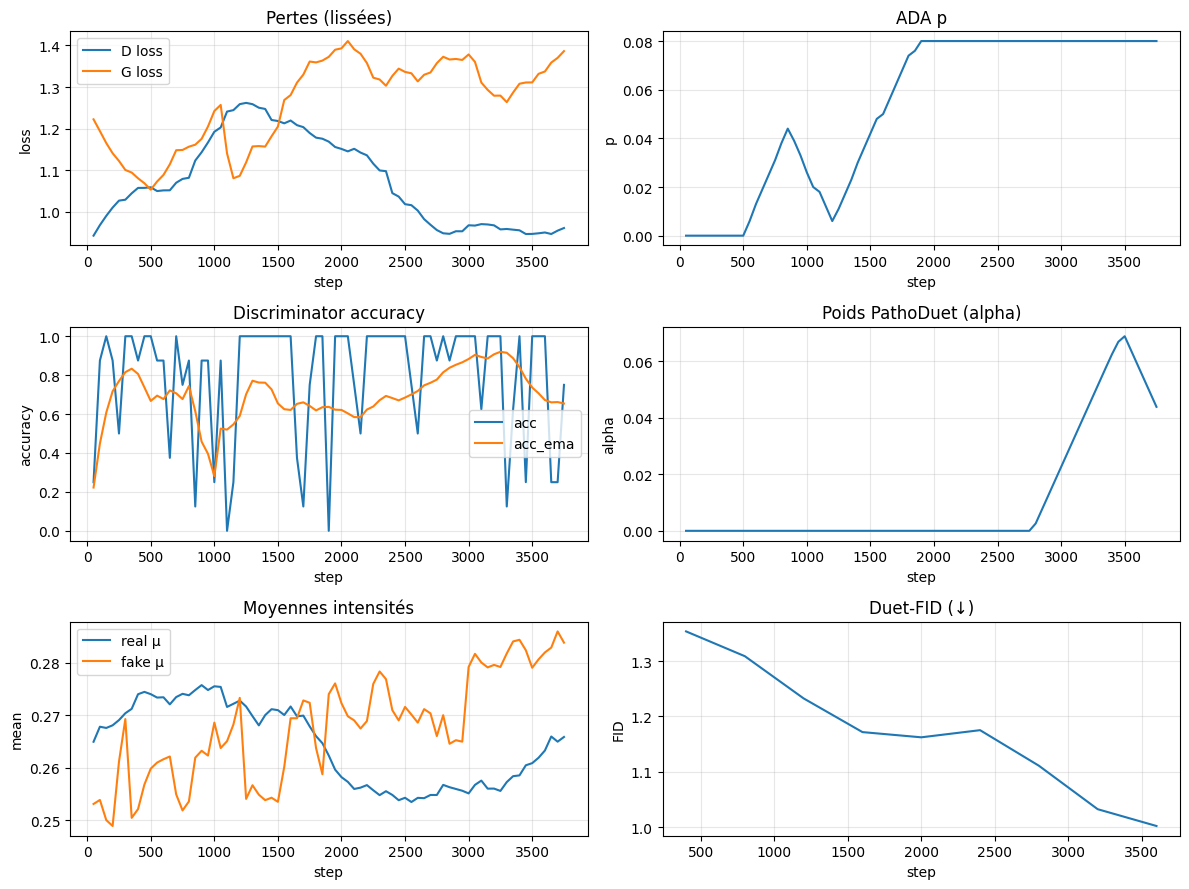

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# --- Chargement métriques entraînement ---
df = pd.read_csv(METRICS_CSV).sort_values("step")

def smooth(s, w=31):
    if len(s) < w: return s
    return s.rolling(w, center=True, min_periods=1).mean()

# --- Chargement Duet-FID (optionnel) ---
duet_csv = METRICS_DIR /"duet_fid.csv"
fid_df = None
if duet_csv.exists():
    fid_df = pd.read_csv(duet_csv)
    # Harmonise le nom de la colonne 'step'
    if "global_step" in fid_df.columns and "step" not in fid_df.columns:
        fid_df = fid_df.rename(columns={"global_step": "step"})
    fid_df = fid_df.sort_values("step")

# --- Grille 3x2 ---
fig, axes = plt.subplots(3, 2, figsize=(12, 9))
(ax1, ax2), (ax3, ax4), (ax5, ax6) = axes

# (1) Pertes lissées
ax1.plot(df["step"], smooth(df["d_loss"]), label="D loss")
ax1.plot(df["step"], smooth(df["g_loss"]), label="G loss")
ax1.set_title("Pertes (lissées)")
ax1.set_xlabel("step"); ax1.set_ylabel("loss")
ax1.legend(); ax1.grid(alpha=0.3)

# (2) ADA p
ax2.plot(df["step"], df["ada_p"])
ax2.set_title("ADA p")
ax2.set_xlabel("step"); ax2.set_ylabel("p")
ax2.grid(alpha=0.3)

# (3) Discriminator accuracy
ax3.plot(df["step"], df["acc"], label="acc")
ax3.plot(df["step"], df["acc_ema"], label="acc_ema")
ax3.set_title("Discriminator accuracy")
ax3.set_xlabel("step"); ax3.set_ylabel("accuracy")
ax3.legend(); ax3.grid(alpha=0.3)

# (4) Poids PathoDuet (alpha) si dispo
if "alpha" in df.columns:
    ax4.plot(df["step"], df["alpha"])
    ax4.set_title("Poids PathoDuet (alpha)")
    ax4.set_xlabel("step"); ax4.set_ylabel("alpha")
    ax4.grid(alpha=0.3)
else:
    ax4.axis("off")
    ax4.set_title("alpha indisponible", loc="left", fontstyle="italic")

# (5) Moyennes intensités
ax5.plot(df["step"], smooth(df["real_mu"]), label="real μ")
ax5.plot(df["step"], smooth(df["fake_mu"]), label="fake μ")
ax5.set_title("Moyennes intensités")
ax5.set_xlabel("step"); ax5.set_ylabel("mean")
ax5.legend(); ax5.grid(alpha=0.3)

# (6) Duet-FID (↓)
if fid_df is not None and "duet_fid" in fid_df.columns:
    ax6.plot(fid_df["step"], smooth(fid_df["duet_fid"], w=15))
    ax6.set_title("Duet-FID (↓)")
    ax6.set_xlabel("step"); ax6.set_ylabel("FID")
    ax6.grid(alpha=0.3)
else:
    ax6.axis("off")
    ax6.set_title("Duet-FID indisponible (pas de CSV)", loc="left", fontstyle="italic")

plt.tight_layout()
plt.show()


In [31]:
import re, time
from pathlib import Path
from PIL import Image

def make_training_gif(
    samples_dir,
    pattern=r"sample_step(\d+)\.png",
    stride=1,                 # prendre 1 image sur `stride` (ex. 3 pour alléger)
    resize_to=None,           # (W,H) ou None pour taille d'origine
    duration_ms=180,          # durée d'une frame (ms)
    loop=0,                   # 0 = boucle infinie
    gif_prefix="training_progress"
):
    """
    Construit un GIF animé à partir des samples sauvegardés.
    Retourne le chemin du GIF créé.
    """
    samples_dir = Path(samples_dir)
    rx = re.compile(pattern)
    files = []
    for p in samples_dir.glob("sample_*.png"):
        m = rx.search(p.name)
        if m:
            step = int(m.group(1))
            files.append((step, p))
    if not files:
        raise FileNotFoundError(f"Aucun sample 'sample_stepXXXXXX.png' dans {samples_dir}")

    files.sort(key=lambda x: x[0])
    files = files[::max(1, int(stride))]

    frames = []
    for step, p in files:
        im = Image.open(p).convert("RGB")
        if resize_to is not None:
            im = im.resize(resize_to, Image.BICUBIC)
        frames.append(im)

    ts = time.strftime("%Y%m%d-%H%M%S")
    gif_path = samples_dir / f"{gif_prefix}_{ts}.gif"
    # Sauvegarde GIF
    frames[0].save(
        gif_path,
        save_all=True,
        append_images=frames[1:],
        duration=duration_ms,
        loop=loop,
        optimize=True,
        disposal=2
    )
    print(f"✅ GIF créé ({len(frames)} frames) -> {gif_path}")
    return str(gif_path)


In [32]:
# 1) Taille d’origine, toutes les images
make_training_gif(SAMPLES_DIR)

# # 2) 1 image sur 3, redimensionné en 768x768, un peu plus rapide
# make_training_gif(SAMPLES_DIR, stride=3, resize_to=(768, 768), duration_ms=120)

# # 3) Lent, grande taille
# make_training_gif(SAMPLES_DIR, resize_to=(1024, 1024), duration_ms=220)


✅ GIF créé (9 frames) -> /workspace/samples/05_stylegan/training_progress_20251121-035330.gif


'/workspace/samples/05_stylegan/training_progress_20251121-035330.gif'